In [2]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/moshida/EUVlitho


In [3]:
import numpy as np
from elitho import source, const

In [4]:
import numpy as np
from elitho import diffraction_amplitude, const, descriptors, diffraction_order

dod_narrow = descriptors.DiffractionOrderDescriptor(1.5)
dod_wide = descriptors.DiffractionOrderDescriptor(6.0)
doc_narrow = diffraction_order.DiffractionOrderCoordinate(
        dod_narrow.max_diffraction_order_x,
        dod_narrow.max_diffraction_order_y,
        diffraction_order.ellipse,
)
doc_wide = diffraction_order.DiffractionOrderCoordinate(
        dod_wide.max_diffraction_order_x,
        dod_wide.max_diffraction_order_y,
        diffraction_order.rounded_diamond,
)

/home/moshida/.pyenv/versions/3.12.11/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from elitho.pupil import find_valid_pupil_points
linput, minput, xinput, n_input = find_valid_pupil_points(doc_wide.num_valid_diffraction_orders)
n_input, np.sum(xinput >= 8)

(1901, np.int64(1749))

In [5]:
# mask with vacuum only
mask_vacuum = np.zeros((const.NDIVX, const.NDIVY), dtype=np.float32)
Ax_vacuum = diffraction_amplitude.diffraction_amplitude("X", mask_vacuum, const.kx0, const.ky0, dod_wide, doc_narrow)
Ax_vacuum.shape

(9, 9, 49)

In [6]:
# mask with vacuum only
mask_absorber = np.ones((const.NDIVX, const.NDIVY), dtype=np.float32)
Ax_absorber = diffraction_amplitude.diffraction_amplitude("X", mask_absorber, const.kx0, const.ky0, dod_wide, doc_narrow)
Ax_absorber.shape

(9, 9, 49)

In [7]:
vcxx = np.zeros((const.nsourceX, const.nsourceY), dtype=np.complex128)
abxx = np.zeros_like(vcxx)
for ls in range(-const.lsmaxX, const.lsmaxX + 1):
    for ms in range(-const.lsmaxY, const.lsmaxY + 1):
        if ( (ls * const.MX / const.dx)**2 + (ms * const.MY / const.dy)**2 ) <= (const.NA / const.wavelength)**2:
            for i in range(doc_narrow.num_valid_diffraction_orders):
                if doc_narrow.valid_x_coords[i] == ls and doc_narrow.valid_y_coords[i] == ms:
                    vcxx[ls + const.lsmaxX, ms + const.lsmaxY] = Ax_vacuum[ls + const.lsmaxX][ms + const.lsmaxY][i]
                    abxx[ls + const.lsmaxX, ms + const.lsmaxY] = Ax_absorber[ls + const.lsmaxX][ms + const.lsmaxY][i]

In [ ]:
phasexx = np.zeros((const.nsourceX, const.nsourceY), dtype=np.complex128)

# 0乗算が発生するらしい. 要確認.
for x in range(const.nsourceX):
    for y in range(const.nsourceY):
        phasexx[x, y] = vcxx[x, y] / np.abs(vcxx[x, y])

/tmp/ipykernel_4193004/700270455.py:6: RuntimeWarning: invalid value encountered in scalar divide
  phasexx[x, y] = vcxx[x, y] / np.abs(vcxx[x, y])


In [9]:
amp_absorber = abxx[const.lsmaxX, const.lsmaxY]
amp_vacuum = vcxx[const.lsmaxX, const.lsmaxY]
amp_absorber, amp_vacuum

(np.complex128(-0.04324679394144204+0.07440892052810588j),
 np.complex128(-0.05791722016805223-0.8007363168226324j))

In [10]:
import numpy as np

with open("assets/masks/mask.bin", "rb") as f:
    packed = np.frombuffer(f.read(), dtype=np.uint8)
unpacked = np.unpackbits(packed)
mask = unpacked.reshape((2048, 2048))

In [11]:
hfpattern = mask * (amp_absorber - amp_vacuum) + amp_vacuum
hfpattern.dtype

dtype('complex128')

In [12]:
# fft with scaling
fft_mask = np.fft.fft2(hfpattern, norm="forward")

In [13]:
fmask = np.zeros((const.noutX, const.noutY), dtype=np.complex128)
# NOTE: NDIVX, NDIVYはもともとFDIVX, FDIVYという名前
for i in range(const.noutX):
    l = (i - const.lpmaxX + const.NDIVX) % const.NDIVX
    for j in range(const.noutY):
        m = (j - const.lpmaxY + const.NDIVY) % const.NDIVY
        fmask[i, j] = fft_mask[l, m]

In [14]:
fampxx = np.zeros((const.noutX, const.noutY), dtype=np.complex128)
for ip in range(const.noutX):
    for jp in range(const.noutY):
        kxp = 2.0 * np.pi * (ip - const.lpmaxX) / const.dx
        kyp = 2.0 * np.pi * (jp - const.lpmaxY) / const.dy
        phasesp = np.exp(-const.i_complex * (const.kx0*kxp + kxp**2/2 + const.ky0*kyp + kyp**2/2) / (const.k * const.z0))
        fampxx[ip, jp] = fmask[ip, jp] * phasesp

In [15]:
fampxx /= phasexx[const.lsmaxX, const.lsmaxY]

In [16]:
params = np.load("assets/params/m3d.npz")
d0, dx, dy = params["d0"], params["dx"], params["dy"]

In [17]:
a0xx = np.zeros((const.noutX, const.noutY), dtype=np.complex128)
axxx = np.zeros_like(a0xx)
ayxx = np.zeros_like(a0xx)
for n in range(n_input):
    ip = linput[n] + const.lpmaxX
    jp = minput[n] + const.lpmaxY
    a0xx[ip, jp] = d0[n]
    if xinput[n] >= 8:
        axxx[ip, jp] = dx[n]
        ayxx[ip, jp] = dy[n]

In [18]:
dkx, dky, SDIV = source.uniform_k_source()

In [25]:
# 複数の計算方法(精度ごとに)があり, どれかを選択して計算する
from enum import Enum
class SimulationMode(Enum):
    FT = 1
    FT_M3D = 2
    
# sim_mode = SimulationMode.FT
sim_mode = SimulationMode.FT_M3D

In [26]:
Ex0m = np.zeros((SDIV, n_input), dtype=complex)
Ey0m = np.zeros_like(Ex0m)
Ez0m = np.zeros_like(Ex0m)

for is_ in range(SDIV):
    kx = const.kx0 + dkx[is_]
    ky = const.ky0 + dky[is_]
    ls = dkx[is_] / (2.0 * np.pi / const.dx)
    ms = dky[is_] / (2.0 * np.pi / const.dy)
    
    for i in range(n_input):
        kxplus = kx + 2 * np.pi * linput[i] / const.dx
        kyplus = ky + 2 * np.pi * minput[i] / const.dy
        kxy2 = kxplus**2 + kyplus**2
        klm = np.sqrt(const.k**2 - kxy2 + 0j)

        ip = linput[i] + const.lpmaxX
        jp = minput[i] + const.lpmaxY
        lp = ip - const.lpmaxX
        mp = jp - const.lpmaxY
        
        
        # NOTE: 一旦下記の実装でいく. 
        # electro_fieldと一緒にできそうな気もするし, できなさそうな気もする. 
        # 座標系が異なることが原因なのか...？ abbeとの違いが.
        Ax = fampxx[ip, jp] / np.sqrt(const.k**2 - kx**2)
        Ay = complex(0)
        
        # if ipl == 0: # X
        if sim_mode == SimulationMode.FT:
            Ax = fampxx[ip, jp] / np.sqrt(const.k**2 - kx**2)
        elif sim_mode == SimulationMode.FT_M3D:
            Ax = (
                fampxx[ip, jp] + a0xx[ip, jp] +
                axxx[ip, jp] * (ls + lp/2.0) +
                ayxx[ip, jp] * (ms + mp/2.0)
            ) / np.sqrt(const.k**2 - kx**2)

        Ay = 0.0 + 0j

        # elif ipl == 1: # Y
        #     if type == 1:
        #         Ay = fampxx[ip, jp] / np.sqrt(const.k**2 - ky**2)
        #     elif type == 2:
        #         Ay = (
        #             fampxx[ip, jp] + a0xx[ip, jp] +
        #             axxx[ip, jp] * (ls + lp/2.0) +
        #             ayxx[ip, jp] * (ms + mp/2.0)
        #         ) / np.sqrt(const.k**2 - ky**2)

        #     Ax = 0.0 + 0j

        EAx = const.i_complex * const.k * Ax - const.i_complex / const.k * (kxplus**2 * Ax + kxplus * kyplus * Ay)
        EAy = const.i_complex * const.k * Ay - const.i_complex / const.k * (kxplus * kyplus * Ax + kyplus**2 * Ay)
        EAz = const.i_complex * klm / const.k * (kxplus * Ax + kyplus * Ay)

        Ex0m[is_][i] = EAx
        Ey0m[is_][i] = EAy
        Ez0m[is_][i] = EAz

In [27]:
from elitho import intensity

intensity_total = np.zeros((const.XDIV, const.XDIV))
for isd in range(SDIV):
    offset_x = dkx[isd]
    offset_y = dky[isd]
    intensity_by_a_source = intensity.intensity_by_abbe_source(
        n_input,
        Ex0m[isd],
        Ey0m[isd],
        Ez0m[isd],
        offset_x,
        offset_y,
        linput,
        minput,
    )
    intensity_total += intensity_by_a_source

intensity_map = intensity_total / SDIV

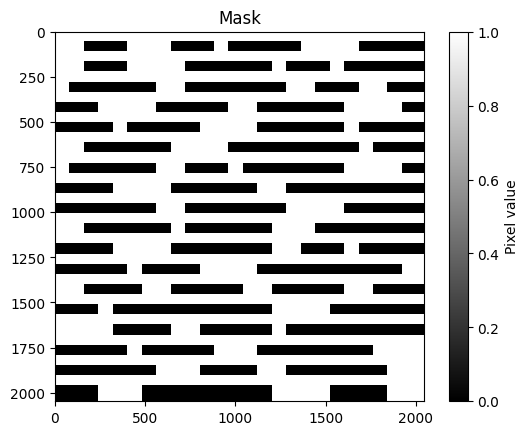

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(mask, cmap='gray', interpolation='nearest')
plt.title("Mask")
plt.colorbar(label="Pixel value")
plt.show()

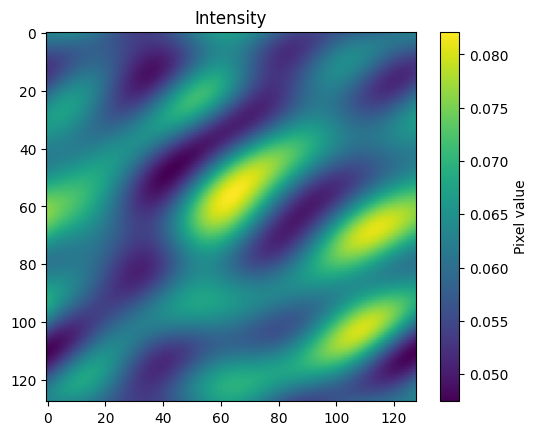

In [24]:
from matplotlib import pyplot as plt
plt.imshow(intensity_map)
plt.title("Intensity")
plt.colorbar(label="Pixel value")
plt.show()

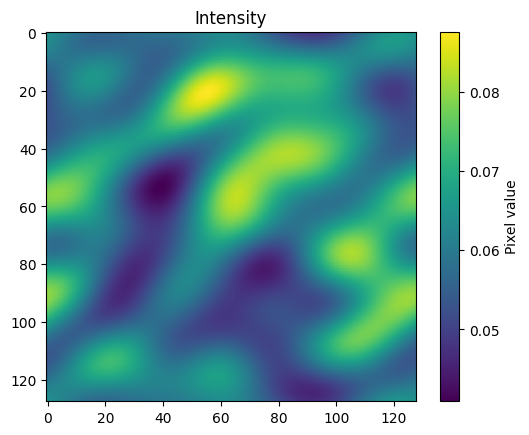

In [28]:
from matplotlib import pyplot as plt
plt.imshow(intensity_map)
plt.title("Intensity")
plt.colorbar(label="Pixel value")
plt.show()